# The Flowers Dataset

$\textbf{About the Dataset}$

 The dataset contains 3670 raw jpeg images of five types of flowers:
- daisy
- dandelion
- rose
- sunflower
- tulip


In the associated folder one will find five folders namely - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip' which contain the images of the respective flowers. In this notebook our goal will be to build a neural network from scratch, and then finetune it to improve the model.

In [1]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exploring the dataset

We start by loading the data from our Drive folder:

In [2]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['roses', 'daisy', 'sunflowers', 'dandelion', 'tulips']


See the distribution of images sizes:

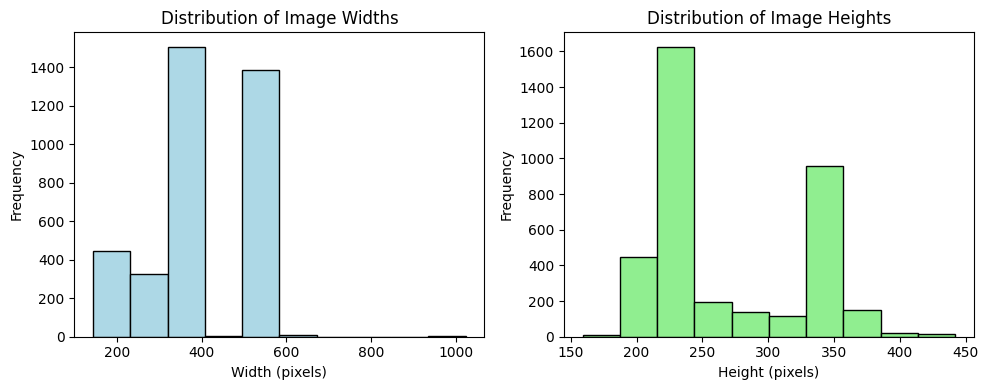

In [ ]:

# Function to get image sizes
def get_image_sizes(folder_path):
    widths = []
    heights = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return widths, heights

# Get image sizes
widths, heights = get_image_sizes('flower_photos')

# Visualize the distribution of image sizes
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='lightblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Checking the image sizes before resizing them to a standard size like 224x224 pixels can be important for several reasons:

1) Data Quality Assessment:

- Anomalies: Detecting images that may have unusual dimensions (e.g., extremely small or large images) can indicate potential data quality issues.
- Consistency: Ensuring that the majority of images are within a reasonable range of sizes can confirm the dataset's overall consistency.

2) Aspect Ratio Preservation:

- Distortion: If images have widely varying aspect ratios, resizing them to a fixed size can distort the images, which may affect model performance. Understanding the aspect ratios can help you decide whether to crop or pad images to maintain aspect ratios.
Resource Planning:

- Memory Usage: Larger images consume more memory and computational resources. Knowing the distribution of image sizes can help in planning the computational resources needed for processing and training.
Preprocessing Strategy:

- Informed Decisions: Insights from the size distribution can guide decisions on preprocessing techniques, such as whether to use resizing, cropping, padding, or other transformations.

Let's see how the classes are distributed:

Labels distribution:
Class: roses , Count: 641 , Perc :17.5%
Class: sunflowers , Count: 699 , Perc :19.0%
Class: tulips , Count: 799 , Perc :21.8%
Class: daisy , Count: 633 , Perc :17.2%
Class: dandelion , Count: 898 , Perc :24.5%


<ipython-input-9-6c79791ebbdc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=class_counts, palette=palette)


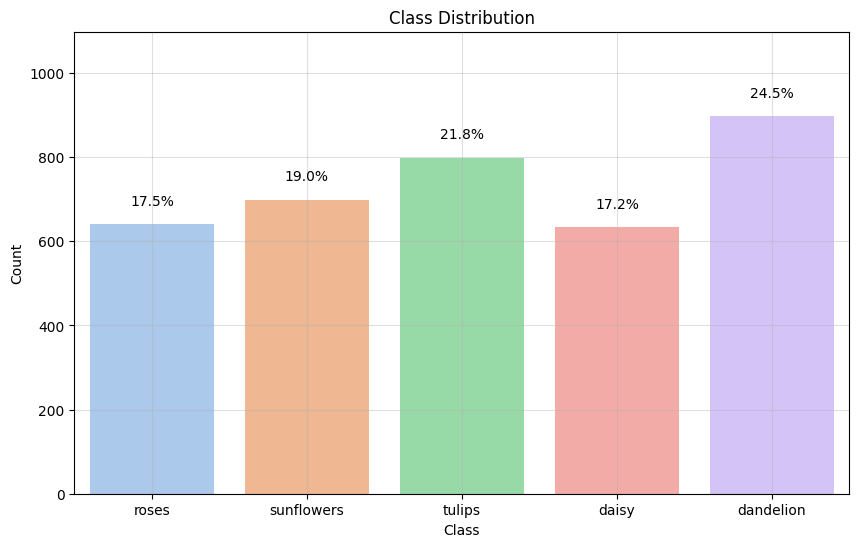

In [ ]:
# Data exploration
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(5):
    print('Class:', class_names[i], ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

palette = sns.color_palette("pastel", len(unique_classes))

plt.figure(figsize=(10, 6))
sns.barplot(x=unique_classes, y=class_counts, palette=palette)

for i, count in enumerate(class_counts):
    percentage = 100 * count / len(y)
    plt.text(i, count + 0.05 * max(class_counts), f'{percentage:.1f}%', ha='center')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes, class_names)
plt.grid(True, alpha=0.4)
plt.ylim(0, max(class_counts) + 200)  # Adjusting y-axis limit to add some space for annotations

#plt.savefig("classes-distribution.png")
#files.download("classes-distribution.png")
plt.show()

We see they are almost evenly distributed, so we will first try to train the neural network without data augmentation. Then, we will augment the data and see if this helps in improving the model.

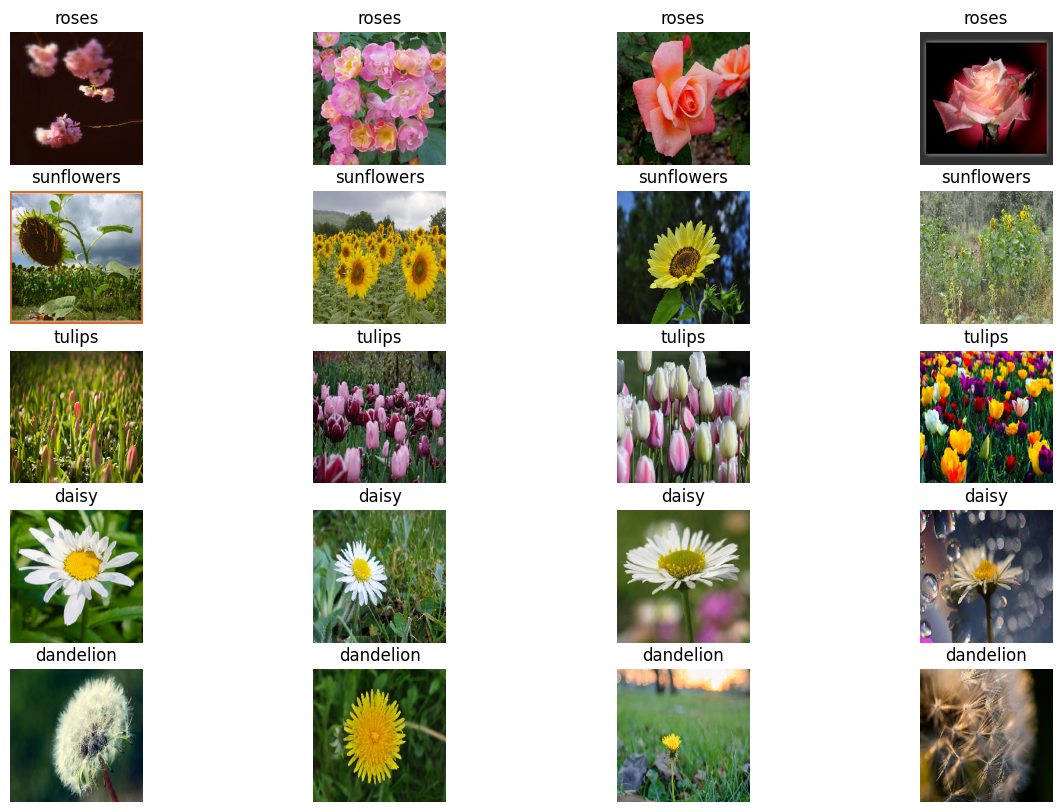

In [ ]:
# Function to display sample images

def display_sample_images(X, y, class_names, samples_per_class=4):
    plt.figure(figsize=(15, 10))
    for cls_idx, class_name in enumerate(class_names):
        idxs = np.where(y == cls_idx)[0]
        selected_idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(selected_idxs):
            plt.subplot(len(class_names), samples_per_class, cls_idx * samples_per_class + i + 1)
            plt.imshow(X[idx].astype("uint8"))
            plt.title(class_name)
            plt.axis('off')
    plt.show()

# Display few samples
display_sample_images(X, y, class_names)

# Preprocessing

We normalize the dataset, and provide the augmentation using the module $\texttt{keras.layers.experimental.preprocessing}$.

In [4]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

Normalizing image data by dividing by 255 is a common practice because pixel values in typical images are represented as integers in the range [0, 255]. This range corresponds to an 8-bit representation of pixel intensities, where 0 represents black and 255 represents white in grayscale images.

In [5]:
# Normalize data first:

X_normalized = X/255.

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [7]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

In [8]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Neural Network

## Without data augmentation

In [ ]:
model = keras.models.Sequential([

    keras.layers.Input(shape=(224, 224, 3)),

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [ ]:
# for the moment fix LR and epochs

lr = 0.001
epochs = 30
n_classes = 5

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
# Encode classes in valid format

y_train_encoded = to_categorical(y_train, n_classes)
y_val_encoded = to_categorical(y_val, n_classes)

# Include if you want to stop when not improving anymore
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
# Fit the model

history = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 11s 48ms/step - loss: 1.4393 - accuracy: 0.3549 - val_loss: 1.1578 - val_accuracy: 0.4850
Epoch 2/30
92/92 [==============================] - 3s 31ms/step - loss: 1.1480 - accuracy: 0.5123 - val_loss: 1.0756 - val_accuracy: 0.5586
Epoch 3/30
92/92 [==============================] - 3s 32ms/step - loss: 1.0225 - accuracy: 0.5807 - val_loss: 0.9076 - val_accuracy: 0.6213
Epoch 4/30
92/92 [==============================] - 3s 35ms/step - loss: 0.9338 - accuracy: 0.6175 - val_loss: 0.9315 - val_accuracy: 0.5913
Epoch 5/30
92/92 [==============================] - 3s 33ms/step - loss: 0.8377 - accuracy: 0.6614 - val_loss: 0.8305 - val_accuracy: 0.6594
Epoch 6/30
92/92 [==============================] - 3s 30ms/step - loss: 0.8031 - accuracy: 0.6849 - val_loss: 0.8633 - val_accuracy: 0.6540
Epoch 7/30
92/92 [==============================] - 3s 32ms/step - loss: 0.7414 - accuracy: 0.7054 - val_loss: 0.7601 - val_accuracy: 0.6866
Epoch 8/30
9

In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
model.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## With data augmentation

In [ ]:
model_aug = keras.models.Sequential([

    data_augmentation, # insert prior to any operation

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Print model summary
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)       

In [ ]:
# Fit the model

history_aug = model_aug.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 8s 51ms/step - loss: 1.4378 - accuracy: 0.3614 - val_loss: 1.2845 - val_accuracy: 0.4523
Epoch 2/30
92/92 [==============================] - 3s 33ms/step - loss: 1.1792 - accuracy: 0.4983 - val_loss: 1.1564 - val_accuracy: 0.4932
Epoch 3/30
92/92 [==============================] - 3s 33ms/step - loss: 1.0883 - accuracy: 0.5429 - val_loss: 1.0734 - val_accuracy: 0.5477
Epoch 4/30
92/92 [==============================] - 3s 35ms/step - loss: 1.0038 - accuracy: 0.5828 - val_loss: 0.9497 - val_accuracy: 0.5804
Epoch 5/30
92/92 [==============================] - 4s 44ms/step - loss: 0.9389 - accuracy: 0.6182 - val_loss: 0.9838 - val_accuracy: 0.5886
Epoch 6/30
92/92 [==============================] - 4s 40ms/step - loss: 0.9035 - accuracy: 0.6202 - val_loss: 0.9344 - val_accuracy: 0.5640
Epoch 7/30
92/92 [==============================] - 3s 32ms/step - loss: 0.8568 - accuracy: 0.6369 - val_loss: 0.8855 - val_accuracy: 0.6240
Epoch 8/30
92

In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
model_aug.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# History results

## Without data augmentation

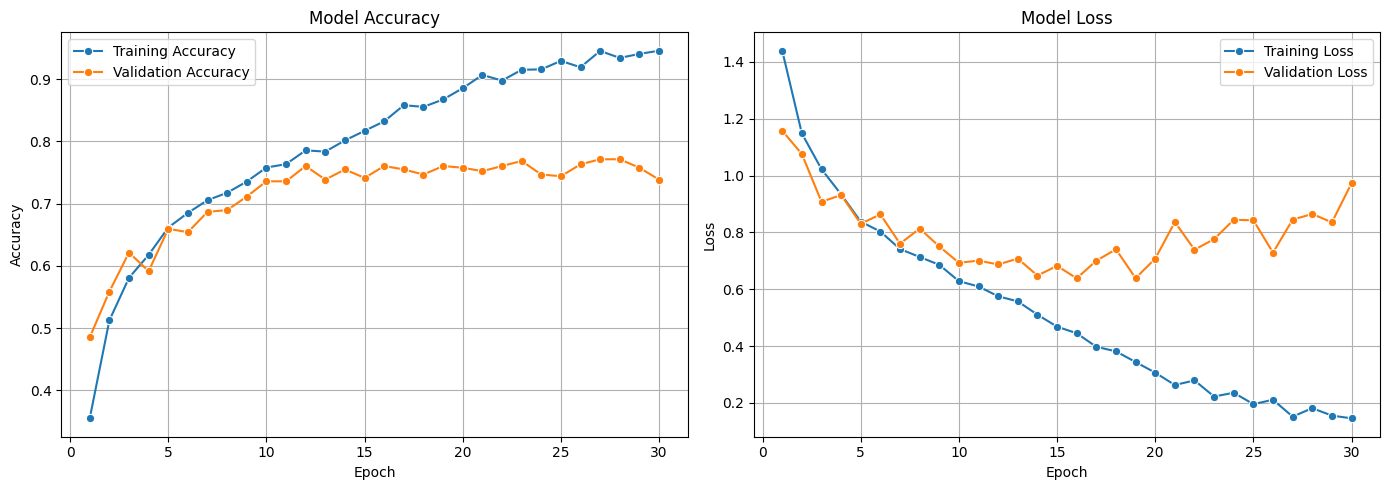

In [ ]:
# Assuming you have the history dictionary loaded
history_dict = history.history

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Add an epoch column
history_df['epoch'] = history_df.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withoutAUG.png")
#files.download("accuracy-withoutAUG.png")
plt.show()

## With data augmentation

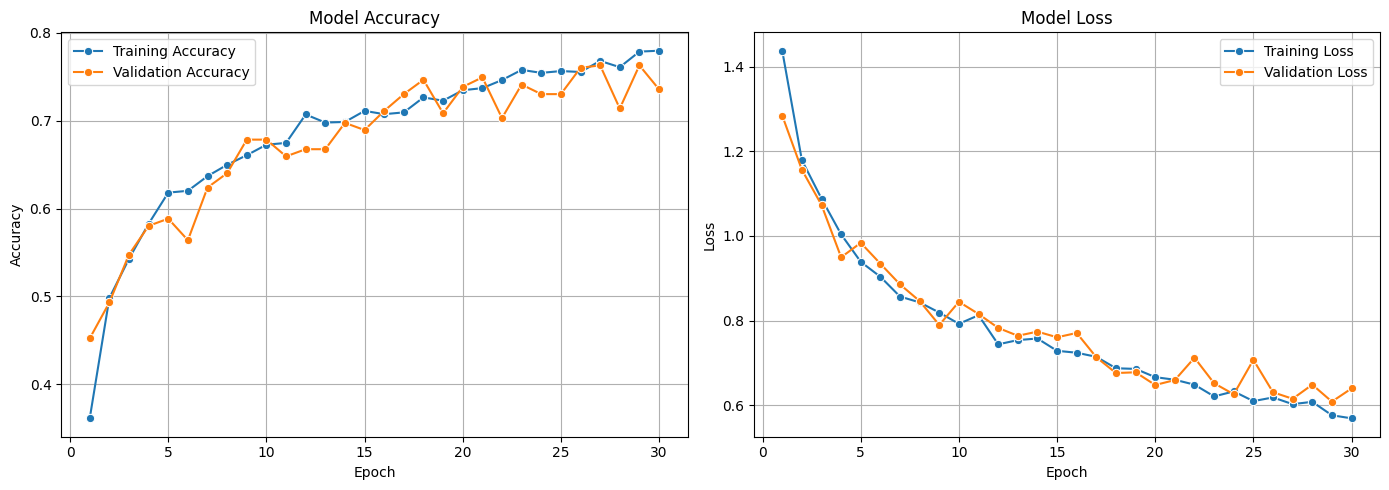

In [ ]:
# Assuming you have the history dictionary loaded
history_dict_aug = history_aug.history

# Create a DataFrame from the history dictionary
history_df_aug = pd.DataFrame(history_dict_aug)

# Add an epoch column
history_df_aug['epoch'] = history_df_aug.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_aug, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_aug, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withAUG.png")
#files.download("accuracy-withAUG.png")
plt.show()

12/12 [==============================] - 0s 19ms/step
Confusion Matrix:
[[39  2 23  6  4]
 [ 1 53  2  1  8]
 [10  4 59  5  5]
 [ 0  1  1 49  6]
 [ 3  3  0  5 77]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

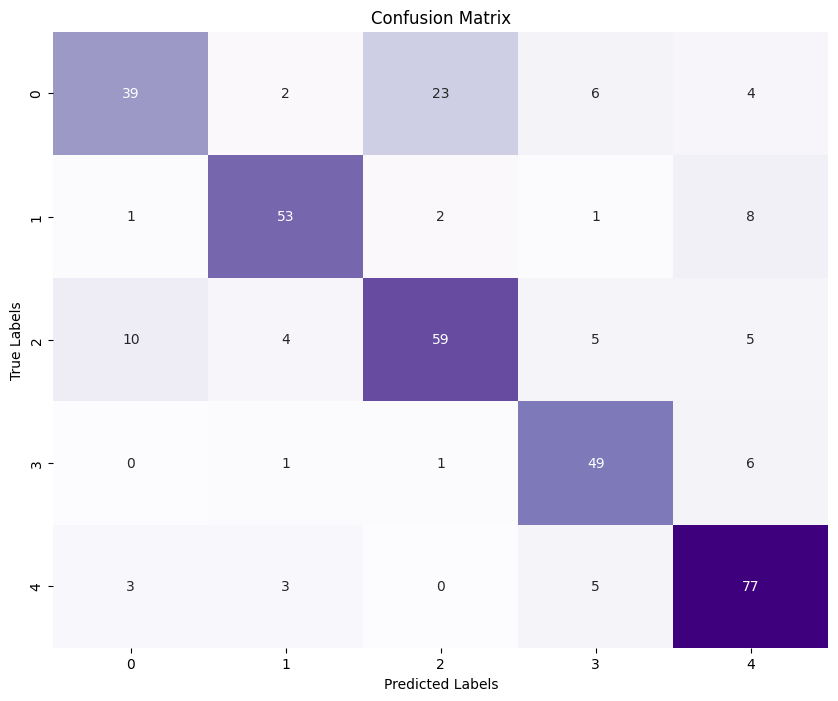

In [ ]:
y_pred_aug = loaded_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)

# Now you can compute the confusion matrix
cm_aug = confusion_matrix(y_test, y_pred_classes_aug)

# Print confusion matrix
print("Confusion Matrix:")
print(cm_aug)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withAUG.png")
files.download("CM-withAUG.png")
plt.show()

12/12 [==============================] - 0s 16ms/step
Confusion Matrix:
[[44  0 21  2  7]
 [ 4 52  2  1  6]
 [11  4 64  2  2]
 [ 5  4  7 37  4]
 [ 0  4  5  0 79]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

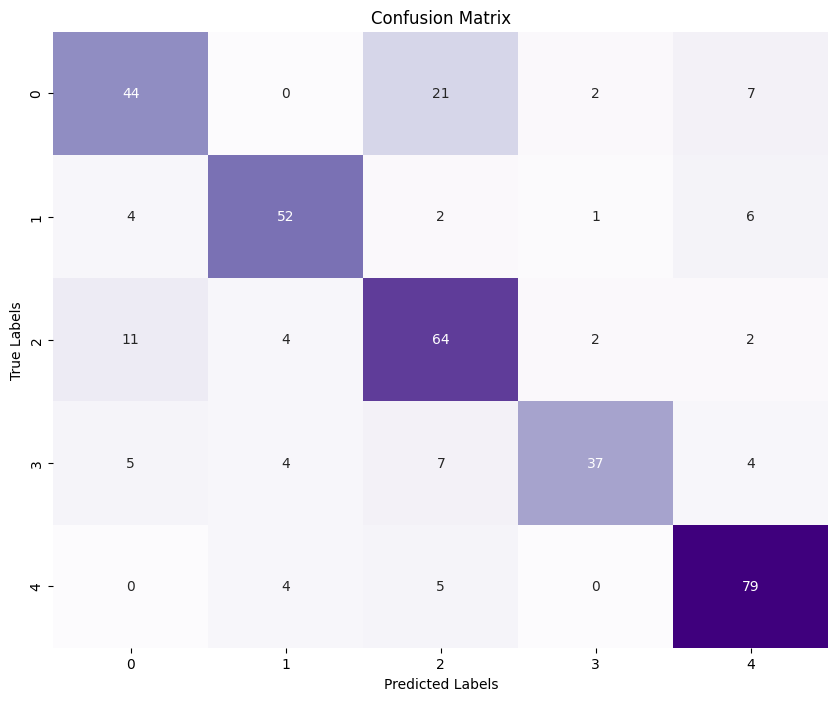

In [ ]:
y_pred = loaded_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withoutAUG.png")
files.download("CM-withoutAUG.png")
plt.show()

# Finetuning

Select only the augmented model so that we can further optimize it.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import backend as K



# Define a function to create your Keras model
def create_model(learning_rate=0.001, optimizer='adam', dropout_rate=0.2):
    model = Sequential([
        data_augmentation,  # insert prior to any operation
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D((3, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D((3, 3)),
        Dropout(dropout_rate),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D((3, 3)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D((3, 3)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer")

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Define the K-Folds cross-validator
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Track the best score and hyperparameters
best_score = 0
best_params = None

# Iterate over all combinations of hyperparameters
for learning_rate in param_grid['learning_rate']:
    for optimizer in param_grid['optimizer']:
        for dropout_rate in param_grid['dropout_rate']:
            fold_scores = []

            # K-Fold Cross Validation
            for train_index, val_index in kfolds.split(X_train):
                X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
                y_fold_train, y_fold_val = y_train_encoded[train_index], y_train_encoded[val_index]

                # Create and train the model
                model = create_model(learning_rate=learning_rate, optimizer=optimizer, dropout_rate=dropout_rate)
                model.fit(X_fold_train, y_fold_train, epochs=5, batch_size=16, verbose=0)  # Reduce epochs and batch size

                # Evaluate the model
                score = model.evaluate(X_fold_val, y_fold_val, verbose=0)
                fold_scores.append(score[1])  # Accuracy

                # Clear the session to free memory
                K.clear_session()

            # Calculate the average score for this set of hyperparameters
            avg_score = np.mean(fold_scores)

            # Update the best score and hyperparameters if necessary
            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'learning_rate': learning_rate,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print("Best hyperparameters:", best_params)
print("Best cross-validated accuracy:", best_score)

# Train the final model on the entire training data with the best hyperparameters
best_model = create_model(learning_rate=best_params['learning_rate'],
                          optimizer=best_params['optimizer'],
                          dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)  # Adjust epochs and batch size as needed

# Evaluate the final model on the test data
final_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print("Final accuracy on the test data:", final_accuracy[1])


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-6b6141582c1d>", line 67, in <cell line: 55>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [16,5] and labels shape [80]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_3120]

# Visualizing results with GradCAM

GradCAM is an algorithm that uses the gradient of the predictions of a CNN with respect to the feature map produced by its last convolutional layer to produce a heatmap that highlights the most influential parts of the image for the network.

We can use it to explore predictions done by the network in order to understand if it's focusing in the correct part of the images.

In [9]:
# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

In [10]:
loaded_model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)       

In [11]:
n_classes=5
y_test_encoded = to_categorical(y_test, n_classes)

## Finding missed predictions
We run the model on the train set and identify which samples it got wrong

In [20]:
y_pred_encoded = loaded_model_aug.predict(X_test)
y_pred_encoded = np.array(y_pred_encoded)
y_pred = np.argmax(y_pred_encoded, axis=1)

12/12 [==============================] - 5s 450ms/step


In [22]:
missed_predictions_indices = np.where(y_pred != y_test)[0]

In [41]:
print("Wrong prediction indices:", missed_predictions_indices[0:25])

Wrong prediction indices: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25
 26]


## GradCAM

In [25]:
last_conv_layer_name = "conv2d_11"  #look at model.summary if mismatched
img_size=(224,224)

In [26]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
loaded_model_aug.layers[-1].activation = None

In [48]:
idx=15
testimage = X_test[idx]
testimage = testimage[np.newaxis,:,:]

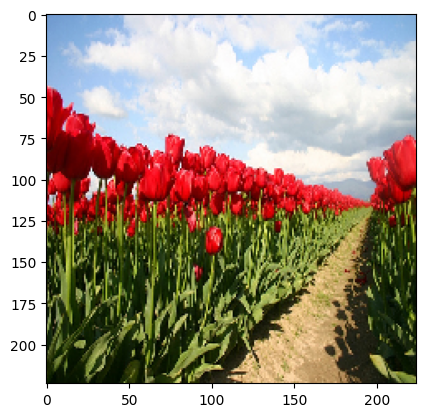

In [49]:
plt.imshow((X_test[idx]*255).astype("uint8"))

In [50]:
preds = loaded_model_aug.predict(testimage)
print("Predicted:", preds)

1/1 [==============================] - 0s 45ms/step
Predicted: [[2.3407459e-01 7.6056612e-01 8.3124483e-05 4.9856124e-03 2.9056423e-04]]


In [51]:
heatmap = make_gradcam_heatmap(testimage, loaded_model_aug, last_conv_layer_name)

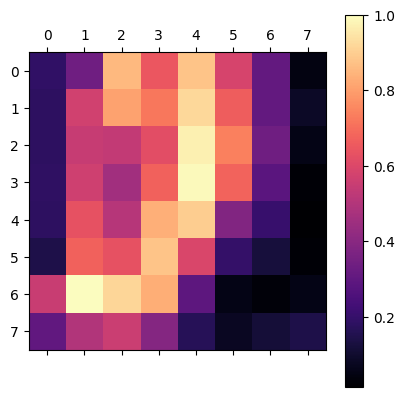

In [52]:
plt.matshow(heatmap, cmap="magma")
plt.colorbar()
plt.show()

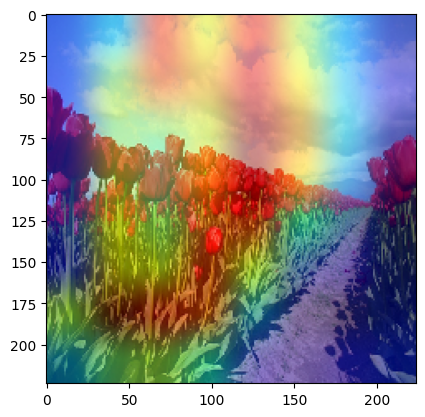

In [53]:
import matplotlib as mpl
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255*heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = superimposed_img[0]
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)


display_gradcam(testimage*255, heatmap, alpha=0.8)